In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import numpy as np
import time
import sys


In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

ncolor = 1
nclass = 10
ntrain = len(x_train)
ntest = len(x_test)

x_train = x_train/255.0
x_train = np.reshape(x_train, (ntrain, -1))
x_test = x_test/255.0
x_test = np.reshape(x_test, (ntest, -1))

labels = np.zeros((ntrain, nclass))
labels[np.arange(ntrain), y_train] = 1
y_train = labels

labels = np.zeros((ntest, nclass))
labels[np.arange(ntest), y_test] = 1
y_test = labels

print("Number of Training Data: ", ntrain)
print("Number of Test Data: ", ntest)
print("Number of class: ", nclass)

Number of Training Data:  60000
Number of Test Data:  10000
Number of class:  10


38691
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


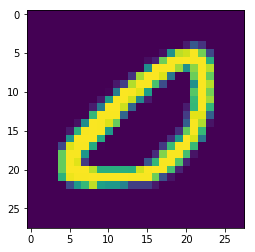

In [3]:
idx = np.random.randint(ntrain)

imgplot = plt.imshow(np.reshape(x_train[idx], (28,28)))
print(idx)
print(y_train[idx])

2383
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


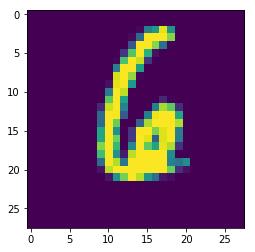

In [4]:
idx = np.random.randint(ntest)

imgplot1 = plt.imshow(np.reshape(x_test[idx], (28,28)))
print(idx)
print(y_test[idx])

In [5]:
class cnn_model(object):
    def __init__(self, sess, img_width, img_height, n_class, lr=1e-4):
        
        n_features = img_width * img_height
        self.sess = sess
        
        self.x = tf.placeholder(tf.float32, [None, 28*28])
        image = tf.reshape(self.x, [-1, 28, 28, 1])              # (batch, height, width, channel)
        self.y_ = tf.placeholder(tf.float32, [None, 10])            # input y
        self.dropout_rate = tf.placeholder(tf.float32)

        with tf.variable_scope('cnn_model'):
            
            # Convolutional layer 1
            conv1 = tf.layers.conv2d(
                inputs=image,
                filters=32,
                kernel_size=5,
                strides=1,
                padding='same',
                activation=tf.nn.relu
            )
            pool1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2,)

            # Convolutional layer 2
            conv2 = tf.layers.conv2d(pool1, 64, 5, 1, 'same', activation=tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(conv2, 2, 2)
            pool2_flat = tf.reshape(pool2, [-1, 7*7*64])

            # Fully connected layer 1
            fc1 = tf.layers.dense(
                inputs=pool2_flat,
                units=1024,    # number of hidden units
                activation=tf.nn.relu,
                kernel_initializer=tf.random_normal_initializer(0., .1),    # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='Dense1'
            )

            # Dropout
            d1 = tf.layers.dropout(inputs=fc1, rate=self.dropout_rate)

            # Fully connected layer 2
            self.output = tf.layers.dense(d1, 10)
            self.y = tf.contrib.layers.softmax(self.output)


            self.loss = tf.reduce_mean(-tf.reduce_sum(self.y_ * tf.log(self.y), reduction_indices=[1]))
            correct_prediction = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
            self.train_op = tf.train.AdamOptimizer(1e-4).minimize(self.loss)
            
#             self.loss = tf.losses.softmax_cross_entropy(onehot_labels=self.y_, logits=output)
#             self.train_op = tf.train.AdamOptimizer(lr).minimize(self.loss)
#             self.accuracy = tf.metrics.accuracy(
#                 labels=tf.argmax(self.y_, axis=1), 
#                 predictions=tf.argmax(output, axis=1),)[1]
            
            
    def train(self, x, y_):
        _, loss = self.sess.run([self.train_op, self.loss], {self.x:x, self.y_:y_, self.dropout_rate:0.5})
        return loss
    
    def predict(self, x, dropout_rate=0.0):
        output = self.sess.run(self.y, {self.x:x, self.dropout_rate:dropout_rate})
        pred_y = np.argmax(output, 1)
        return [output, pred_y]
    
    def evaluate(self, x, y_):
        acc, loss = self.sess.run([self.accuracy, self.loss], {self.x:x, self.y_:y_, self.dropout_rate:0.0})
        return [acc, loss]

In [6]:
# sess = tf.Session()
# cnn = cnn_model(sess, 28, 28, nclass, 0.001)

# sess.run(tf.global_variables_initializer())

# batch_size = 1024

# for step in range(600):
#     start = step * batch_size
#     end = min((step+1) * batch_size, ntrain)    
#     training_data = x_train[start: end]
#     training_labels = y_train[start: end]

#     cnn.train(training_data, training_labels)

# print("Training End")

In [7]:
# ######Ouptut layer size determined by labeling function
# output_layer_size = nclass

# ######Here is the neural net model described in Tensor Flow MNIST example
# def weight_variable(shape):
#   initial = tf.truncated_normal(shape, stddev=0.1)
#   return tf.Variable(initial)

# def bias_variable(shape):
#   initial = tf.constant(0.1, shape=shape)
#   return tf.Variable(initial)

# def conv2d(x, W):
#   return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# def max_pool_2x2(x):
#   return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
#                         strides=[1, 2, 2, 1], padding='VALID')

# x  = tf.placeholder(tf.float32, [None, 784], name='x')
# x_image = tf.reshape(x, [-1, 28, 28, 1])
# y_ = tf.placeholder(tf.float32, [None, output_layer_size],  name='y_')

# # Convolutional layer 1
# W_conv1 = weight_variable([5, 5, 1, 32])
# b_conv1 = bias_variable([32])
# h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
# h_pool1 = max_pool_2x2(h_conv1)

# # Convolutional layer 2
# W_conv2 = weight_variable([5, 5, 32, 64])
# b_conv2 = bias_variable([64])
# h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# h_pool2 = max_pool_2x2(h_conv2)

# # Fully connected layer 1
# h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
# W_fc1 = weight_variable([7 * 7 * 64, 1024])
# b_fc1 = bias_variable([1024])
# h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# # Dropout
# keep_prob  = tf.placeholder(tf.float32)
# h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# # Fully connected layer 2 (Output layer)
# W_fc2 = weight_variable([1024, output_layer_size])
# b_fc2 = bias_variable([output_layer_size])

# y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name='y')

# # Evaluation functions
# cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

# correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

# # Training algorithm
# train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [8]:

def ranker_random(examples, cnn, sess=None):
    return np.random.randint(10, size=len(examples))

def ranker_max_min(examples, cnn, sess):
    s, pred_y = cnn.predict(examples)
    ranked = np.max(s, axis=1) - np.min(s, axis=1)
    return ranked

def ranker_best_second(examples, cnn, sess):
    s, pred_y = cnn.predict(examples)
    s = np.sort(s, axis=1)
    ranked = s[-1] - s[-2]
    return ranked

# def ranker_bayesian(examples, cnn, sess):
#     predicts = np.asarray([sess.run(y, feed_dict={x: examples, keep_prob: 0.5}) for i in range(15)])
#     var = np.var(predicts, axis=0)
#     var_sum = np.sum(var, axis=1)
#     return var_sum


In [9]:
# TODO: rename batch_size, return np array instead of list

###### Ranks mnist training images according to a rank function (random for normal, 
###### model evaluation for active learning)
def choose_examples(cnn, datas = x_train, remain = [], batch_size = 50, ranker = ranker_random, chosen = [], sess = None):

    #do not look at examples that have already been seen
    lookup_index = range(0, ntrain)
    look_size = min(batch_size * 30, len(remain))
    random_draw = random.sample(range(len(remain)), look_size)

    #rank the examples according to the rank function
    remain_idx = remain[random_draw]
    remain_data = datas[remain_idx]
    remain = np.delete(remain, idx)
    ranks = ranker(remain_data, cnn, sess)
    scores = np.column_stack((remain_idx, ranks))
    sort = scores[np.argsort(scores[:,1])]

    #select examples based on their scores. we only pick the first {batch_size}th of data
    batch_size = min(batch_size, len(scores))
    selected = sort[:batch_size, 0]
    return [selected.astype(int).tolist(), remain]

In [10]:
######trains one model on a subset of mnist data for a certian number of epochs
def epoch_sample(cnn, chosen, batch_size, epochs, sess):
    
    sess.run(tf.global_variables_initializer())
    runs = int(len(chosen) / batch_size)

    for epoch in range(epochs):
        random.shuffle(chosen)
        
        for i in range(runs):
            end = min((i + 1) * batch_size, len(chosen)-1)
            batch_idx = chosen[i * batch_size: end]
            training_data = x_train[batch_idx]
            training_labels = y_train[batch_idx]
#             sess.run(train_step, feed_dict={x: training_data, y_: training_labels, keep_prob: 0.5})
            cnn.train(training_data, training_labels)

#     [epoch_acc, epoch_ce] = sess.run([accuracy, cross_entropy], feed_dict={x: x_test, y_: y_test, keep_prob: 1.0})
    [acc, ce] = cnn.evaluate(x_test, y_test)
    print("Labels: ", len(chosen), " Epochs: ", epochs, " Acc: ", acc, " Cross Entropy: ", ce)
    
    return [acc, ce]

In [11]:

def run_batch(size, max_steps, ranker, print_every):
    #run_log = []
    #batch_log = []
    chosen = []
    remain = np.arange(ntrain)

    sess = tf.Session()
        
    cnn = cnn_model(sess, 28, 28, 10, 0.001)
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()) # the local var is for accuracy_op
    sess.run(init_op)

    print("Select Active Learning Dataset")
    timer1 = 0
    timer2 = 0
    for step in range(max_steps):

        start_time = time.time()
        #if re-sampling turned on, will double size of the mini-batch
        #by randomly sampling from previously trained on exmaples
        next_batch, remain = choose_examples(cnn, x_train, remain, size, ranker, chosen, sess)
        chosen = chosen + next_batch
        if len(remain) <= 0:
            remain = np.arange(ntrain)

        batch_xs = x_train[next_batch]
        batch_ys = y_train[next_batch]
        end_time = time.time()
        timer1 = timer1 + end_time - start_time

        #Train the model using the mini-batch
        start_time = time.time()
#             sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
        cnn.train(batch_xs, batch_ys)

        if (step % print_every) == 0:
#                 [acc, ce] = sess.run([accuracy, cross_entropy], feed_dict={x: x_test, y_: y_test, keep_prob: 1.0})
            [acc, ce] = cnn.evaluate(x_test, y_test)
#                 print(acc)
#                 run_log.append([step, acc, ce])
        end_time = time.time()
        timer2 = timer2 + end_time - start_time

    print(timer1)
    print(timer2)
#         [final, final_ce] = sess.run([accuracy, cross_entropy], feed_dict={x: x_test, y_: y_test, keep_prob: 1.0})
    [final, final_ce] = cnn.evaluate(x_test, y_test)
    #run_log.append([max_steps, final, final_ce])
    #batch_log.append(run_log)

    #start multi-epoch portion (kind of pasted on at the end)
    epoch_logs = []
    label_range = 250
    epochs = 20
    epoch_batch_size = 50
    iteration = 20

    print("\nStart Training the Network with the selected Dataset")
    start_time = time.time()
    #for label_size in range(iteration):
    labels_length = (iteration + 1) * label_range
    result = epoch_sample(cnn, chosen[0: labels_length], epoch_batch_size, epochs, sess)
    end_time = time.time()
    print(end_time - start_time)
    #epoch_logs.append([labels_length, epochs, result[0], result[1]])

#         print("labels\tepoch\taccuracy\tcross entropy")
#         for entry in epoch_logs:
#             print(entry[0], "\t", entry[1], "\t", entry[2], "\t", entry[3])
    print("\nFinish Training")
    #return batch_log
    return

In [12]:
#def print_average_series(to_average, columns, column_names):
#    labels = [int(a[0]) for a in to_average[0]]
#   column_collection = []
#   for column in columns:
#         transformed = []
#         for run in to_average:
#             transformed.append([a[column] for a in run])
#         column_collection.append(np.mean(np.transpose(transformed), axis=1))
#     column_collection.insert(0, np.array(labels))
#     column_names.insert(0, 'iteration')
#     print(*column_names, sep='\t')
#     for row in np.transpose(column_collection):
#         print(*row, sep='\t')

In [13]:
batch_size = 10
iterations = 1000
print_every = 100
ranker = ranker_max_min


start_time = time.time()


results = run_batch(batch_size, iterations, ranker, print_every)
#pint_average_series(results, [1, 2], ["accuracy", "cross entropy"])


end_time = time.time()
print(end_time - start_time)


Select Active Learning Dataset
10.942887783050537
8.227154731750488

Start Training the Network with the selected Dataset
Labels:  5250  Epochs:  20  Acc:  0.9885  Cross Entropy:  0.03518779
16.50696110725403

Finish Training
37.06350302696228
